# ML from Scratch: From attention to transformers

* Author: Binxu Wang (binxu_wang@hms.harvard.edu)

* Date: Apr.17th, 2023


In this first tutorial, we want to dive into the details of attention mechanism. If you are interested, you'd be able to implement self-attention layer and build your own transformer model from scratch.

For most established library e.g. `torch`, the code is a bit harder to read, due to efficiency optimization and feature flexibility (numerous `if` `else` path). So here we will develop **a more readable but equivalent model**, and validate it against the offcial implementation.

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Self-Attention Mechanism: Single Head

![](https://raw.githubusercontent.com/Animadversio/TransformerFromScratch/main/media/AttentionSchematics_white-01.png)

In [3]:
embdim = 256
headdim = 64
tokens = torch.randn(1, 5, embdim) # batch, tokens, embedding
Wq = torch.randn(embdim, headdim) / math.sqrt(embdim)
Wk = torch.randn(embdim, headdim) / math.sqrt(embdim)
Wv = torch.randn(embdim, embdim) / math.sqrt(embdim)

Fill in the score matrix computation

In [4]:
qis = torch.einsum("BSE,EH->BSH", tokens, Wq) # batch x seqlen x headdim
kis = torch.einsum("BTE,EH->BTH", tokens, Wk) # batch x seqlen x headdim
vis = torch.einsum("BTE,EF->BTF", tokens, Wv) # batch x seqlen x embeddim
# Your code here
scoremat = torch.einsum("BSH,BTH->BST",qis,kis) # output: batch x seqlen (Query) x seqlen (Key)
####
attmat = F.softmax(scoremat / math.sqrt(headdim), dim=2)

Some checks to make sure the score correspond to the product of the right pair.

In [5]:
assert(torch.isclose(scoremat[0,1,2], qis[0,1,:]@kis[0,2,:]))
assert(torch.isclose(scoremat[0,3,4], qis[0,3,:]@kis[0,4,:]))
assert(torch.isclose(scoremat[0,2,2], qis[0,2,:]@kis[0,2,:]))

In [6]:
zis = torch.einsum("BST,BTF->BSF", attmat, vis)

In pytorch, these operations are packed int the function `F.scaled_dot_product_attention`. So let's test our implementation of the single head attention against it.

In [7]:
attn_torch = F.scaled_dot_product_attention(qis,kis,vis)
assert(torch.allclose(attn_torch, zis, atol=1E-6,rtol=1E-6))

## Multi-head attention

In [8]:
embdim = 768
headcnt = 12
headdim = embdim // headcnt
assert headdim * headcnt == embdim
tokens = torch.randn(1, 5, embdim) # batch, tokens, embedding
Wq = torch.randn(embdim, headcnt * headdim) / math.sqrt(embdim) # heads packed in a single dim
Wk = torch.randn(embdim, headcnt * headdim) / math.sqrt(embdim) # heads packed in a single dim
Wv = torch.randn(embdim, headcnt * headdim) / math.sqrt(embdim) # heads packed in a single dim

In [9]:
batch, token_num, _ = tokens.shape
qis = torch.einsum("BSE,EH->BSH", tokens, Wq)
kis = torch.einsum("BTE,EH->BTH", tokens, Wk)
vis = torch.einsum("BTE,EH->BTH", tokens, Wv)
# split the single hidden dim into the heads
qis_mh = qis.view(batch, token_num, headcnt, headdim)
kis_mh = kis.view(batch, token_num, headcnt, headdim)
vis_mh = vis.view(batch, token_num, headcnt, headdim)

Now your challenge is to compute multihead attention using `einsum`

In [10]:
# YOUR CODE HERE
scoremat_mh = torch.einsum("BSHD,BTHD->BHST",qis_mh,kis_mh)  # Output: batch x headcnt x seqlen (query) x seqlen (key)
# End
attmat_mh = F.softmax(scoremat_mh / math.sqrt(headdim), dim=-1)
zis_mh = torch.einsum("BCST,BTCH->BSCH", attmat_mh, vis_mh)  # batch x seqlen (query) x headcnt x headdim
zis = zis_mh.reshape(batch, token_num, headcnt * headdim)

Let's validate the tensor multiplication is correct

In [11]:
# raw attention score of the 1st attention head
assert (torch.allclose(scoremat_mh[0, 1], qis_mh[0,:,1] @ kis_mh[0,:,1,:].T))

In [12]:
print(tokens.shape)
print(qis_mh.shape)
print(kis_mh.shape)
print(vis_mh.shape)
print(attmat_mh.shape)
print(zis_mh.shape)
print(zis.shape)

torch.Size([1, 5, 768])
torch.Size([1, 5, 12, 64])
torch.Size([1, 5, 12, 64])
torch.Size([1, 5, 12, 64])
torch.Size([1, 12, 5, 5])
torch.Size([1, 5, 12, 64])
torch.Size([1, 5, 768])


In `torch` this operation is packed in `nn.MultiheadAttention`, including the input projection, attention and out projection. So, note the input the the `mha.forward` function are the *token_embeddings* not the Q,K,Vs as we put it in `F.scaled_dot_product_attention`

In [13]:
mha = nn.MultiheadAttention(embdim, headcnt, batch_first=True,)
print(mha.in_proj_weight.shape) # 3 * embdim x embdim
mha.in_proj_weight.data = torch.cat([Wq, Wk, Wv], dim=1).T

torch.Size([2304, 768])


In [14]:
attn_out, attn_weights = mha(tokens, tokens, tokens, average_attn_weights=False,)
assert torch.allclose(attmat_mh, attn_weights, atol=1e-6, rtol=1e-6)

In `nn.MultiheadAttention` , there is a output projection `out_proj`, projecting the values. It is a linear layer with bias. We can validate that going through this projection our outputs `zis` is the same as the output of `mha`

In [15]:
print(mha.out_proj)
assert torch.allclose(attn_out, mha.out_proj(zis), atol=1e-6, rtol=1e-6)

NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)


### Causal attention mask

For models such as GPT, each token can only attend to tokens before it, thus the attention score needs to be modified before entering softmax.

The common way of masking is to add a large negative number to the locations that you'd not want the model to attend to.

In [16]:
attn_mask = torch.ones(token_num,token_num,)
attn_mask = -1E4 * torch.triu(attn_mask,1)
attn_mask

tensor([[    -0., -10000., -10000., -10000., -10000.],
        [    -0.,     -0., -10000., -10000., -10000.],
        [    -0.,     -0.,     -0., -10000., -10000.],
        [    -0.,     -0.,     -0.,     -0., -10000.],
        [    -0.,     -0.,     -0.,     -0.,     -0.]])

In [17]:
scoremat_mh_msk = torch.einsum("BSCH,BTCH->BCST", qis_mh, kis_mh)  # batch x headcnt x seqlen (query) x seqlen (key)
scoremat_mh_msk += attn_mask  # add the attn mask to the scores before SoftMax normalization
attmat_mh_msk = F.softmax(scoremat_mh_msk / math.sqrt(headdim), dim=-1)
zis_mh_msk = torch.einsum("BCST,BTCH->BSCH", attmat_mh_msk, vis_mh)  # batch x seqlen (query) x headcnt x headdim
# zis_mh = torch.einsum("BSCT,BTCH->BSCH", attmat_mh, vis_mh)
zis_msk = zis_mh_msk.reshape(batch, token_num, headcnt * headdim)

**Note** `is_causal` parameter should work and create a causal mask automatically. But in a recent pytorch bug, it doesn't work. So beware~
https://github.com/pytorch/pytorch/issues/99282

In [18]:
attn_out_causal, attn_weights_causal = mha(tokens, tokens, tokens, average_attn_weights=False, attn_mask=attn_mask)

In [19]:
assert torch.allclose(attn_weights_causal, attmat_mh_msk, atol=1e-6, rtol=1e-6)
assert torch.allclose(attn_out_causal, mha.out_proj(zis_msk), atol=1e-6, rtol=1e-6)

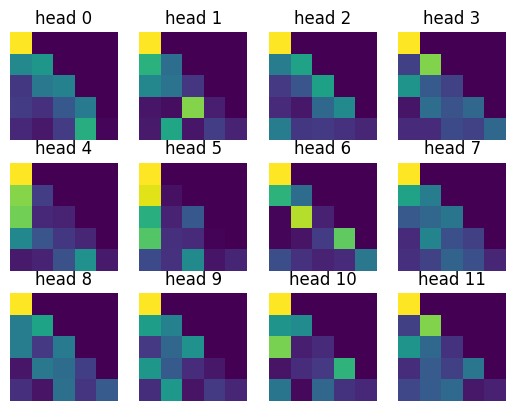

In [20]:
plt.figure()
for head in range(headcnt):
    plt.subplot(3, 4, head + 1)
    plt.imshow(attn_weights_causal[0, head].detach().numpy())
    plt.title(f"head {head}")
    plt.axis("off")
plt.show()

## Transformer Block

Having gaining some intuition about attention layer, let's build it into a transformer. An vanilla transformer block usually looks like this. Note there are slight difference between the transformer blocks in GPT2, BERT and other models, but they generally has the following components

* Transformer Block
  * Layernorm
  * Skip connections
  * Multi-head attention
  * MLP, Feedforward net


In [21]:
class TransformerBlock_simple(nn.Module):

    def __init__(self, embdim, headcnt, *args, dropout=0.0, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.ln1 = nn.LayerNorm(embdim)
        self.ln2 = nn.LayerNorm(embdim)
        self.attn = nn.MultiheadAttention(embdim, headcnt, batch_first=True,)
        self.ffn = nn.Sequential(
            nn.Linear(embdim, 4 * embdim),
            nn.GELU(),
            nn.Linear(4 * embdim, embdim),
            nn.Dropout(dropout),
        )

    def forward(self, x, is_causal=True):
        batch, token_num, hidden_dim = x.shape
        if is_causal:
            attn_mask = torch.ones(token_num, token_num,)
            attn_mask = -1E4 * torch.triu(attn_mask,1)
        else:
            attn_mask = None

        residue = x
        x = self.ln1(x)
        attn_output, attn_weights = self.attn(x, x, x, attn_mask=attn_mask)  # first output is the output latent states
        x = residue + attn_output

        residue = x
        x = self.ln2(x)
        ffn_output = self.ffn(x)
        output = residue + ffn_output
        return output

Compare the implmentation with the schematics and see if it makes more sense!


**BERT**

![BERT (Transformer encoder)](https://iq.opengenus.org/content/images/2020/06/encoder-1.png)

**GPT2**

![](https://miro.medium.com/v2/1*jbcwhhB8PEpJRk781rML_g.png)

## Example: GPT2 from `Transformers` library

In [22]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 3.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [23]:
#@title Printing utils
import torch
import torch.nn as nn
def recursive_print(module, prefix="", depth=0, deepest=3):
    """Simulating print(module) for torch.nn.Modules
        but with depth control. Print to the `deepest` level. `deepest=0` means no print
    """
    if depth == 0:
        print(f"[{type(module).__name__}]")
    if depth >= deepest:
        return
    for name, child in module.named_children():
        if len([*child.named_children()]) == 0:
            print(f"{prefix}({name}): {child}")
        else:
            if isinstance(child, nn.ModuleList):
                print(f"{prefix}({name}): {type(child).__name__} len={len(child)}")
            else:
                print(f"{prefix}({name}): {type(child).__name__}")
        recursive_print(child, prefix + "  ", depth + 1, deepest)

In [24]:
from transformers import GPT2Tokenizer, GPT2Model

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

Let's first look at the general architecture of GPT2 (small), it's actually simple and elegant.
* `wte` token embedding
* `wpe` position embedding
* `h` sequence of Transformer blocks
* `LayerNorm` final normalization

In [25]:
recursive_print(model, deepest=2)

[GPT2Model]
(wte): Embedding(50257, 768)
(wpe): Embedding(1024, 768)
(drop): Dropout(p=0.1, inplace=False)
(h): ModuleList len=12
  (0): GPT2Block
  (1): GPT2Block
  (2): GPT2Block
  (3): GPT2Block
  (4): GPT2Block
  (5): GPT2Block
  (6): GPT2Block
  (7): GPT2Block
  (8): GPT2Block
  (9): GPT2Block
  (10): GPT2Block
  (11): GPT2Block
(ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)


Within each GPT2block, you can see the similarity with our model

In [26]:
recursive_print(model.h[0], deepest=2)

[GPT2Block]
(ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
(attn): GPT2Attention
  (c_attn): Conv1D()
  (c_proj): Conv1D()
  (attn_dropout): Dropout(p=0.1, inplace=False)
  (resid_dropout): Dropout(p=0.1, inplace=False)
(ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
(mlp): GPT2MLP
  (c_fc): Conv1D()
  (c_proj): Conv1D()
  (act): NewGELUActivation()
  (dropout): Dropout(p=0.1, inplace=False)


### GPT in action

In [27]:
inputs = tokenizer("I have a cat, her name is", return_tensors="pt")
outputs = model(**inputs, output_attentions=True, output_hidden_states=True)

The tokens model reads are the following

In [28]:
token_strs = tokenizer.tokenize("I have a cat, her name is")
print(token_strs)
token_strs = [tok.replace("Ġ","") for tok in token_strs]

['I', 'Ġhave', 'Ġa', 'Ġcat', ',', 'Ġher', 'Ġname', 'Ġis']


In [29]:
print("Shape of final output token vectors", outputs.last_hidden_state.shape)
# attention of each GPTBlock:
print("num of attention outputs", len(outputs.attentions))
# shape of each attention tensor: [batch, heads, token (source), token (target)]
print("shape of each attention tensor", outputs.attentions[-1].shape)
print("num of hidden states (input embed included.) ", len(outputs.hidden_states))
print("shape of each hidden states tensor", outputs.hidden_states[-1].shape) #[batch, token, hidden]
assert torch.allclose(outputs.hidden_states[-1], outputs.last_hidden_state)

Shape of final output token vectors torch.Size([1, 8, 768])
num of attention outputs 12
shape of each attention tensor torch.Size([1, 12, 8, 8])
num of hidden states (input embed included.)  13
shape of each hidden states tensor torch.Size([1, 8, 768])


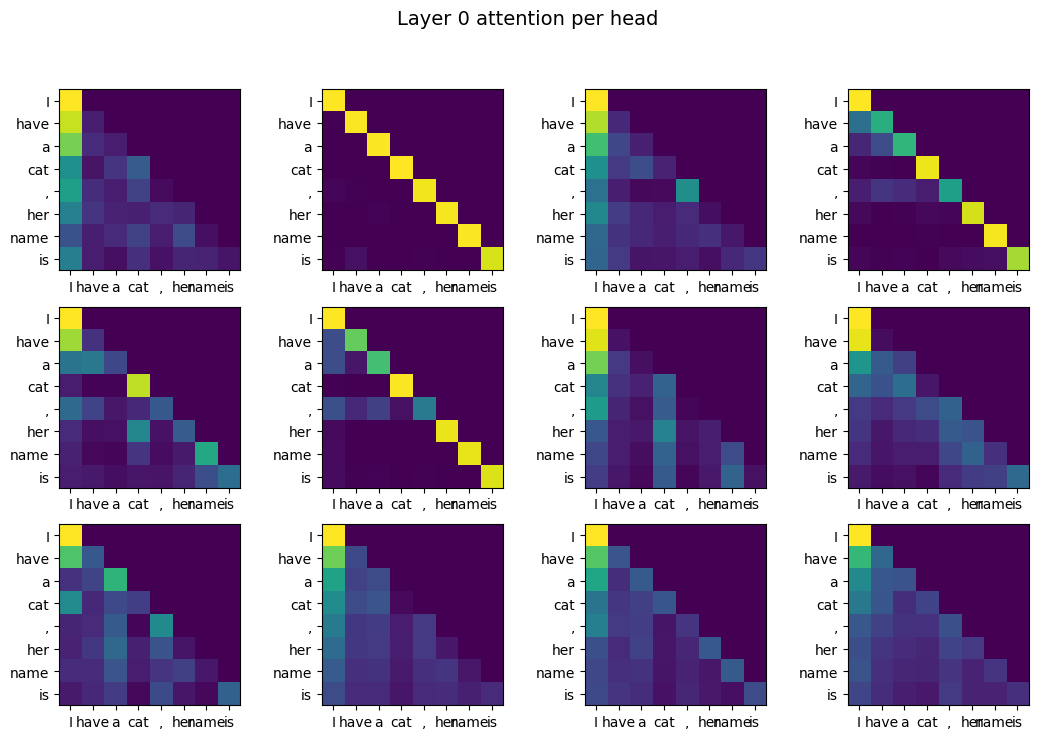

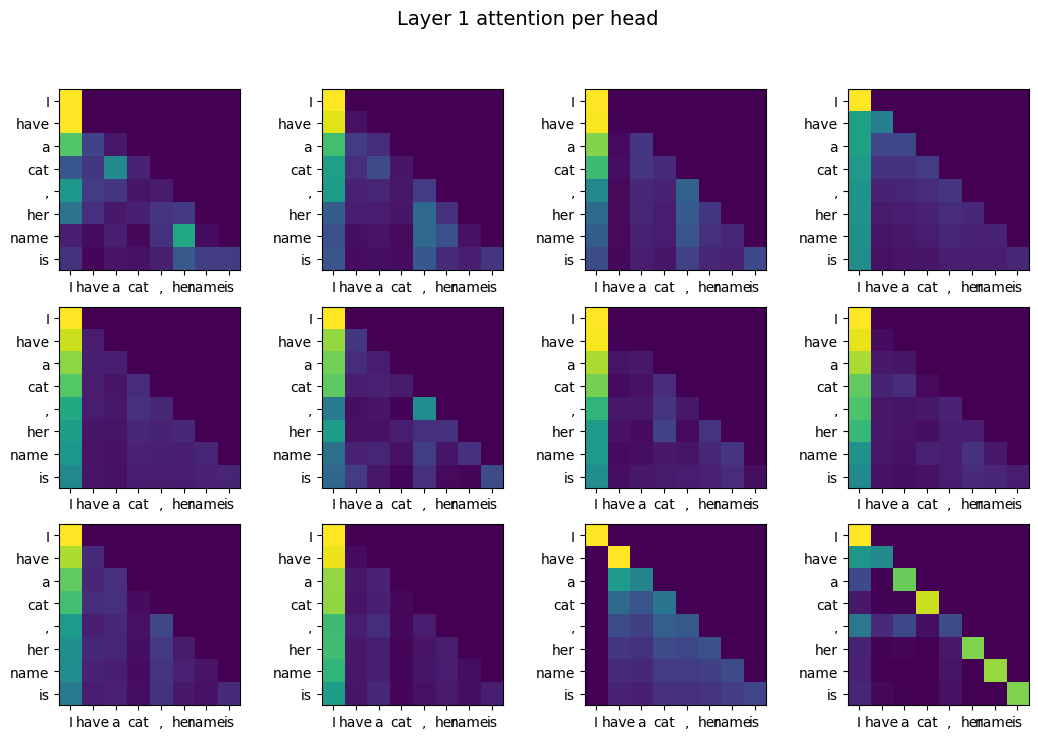

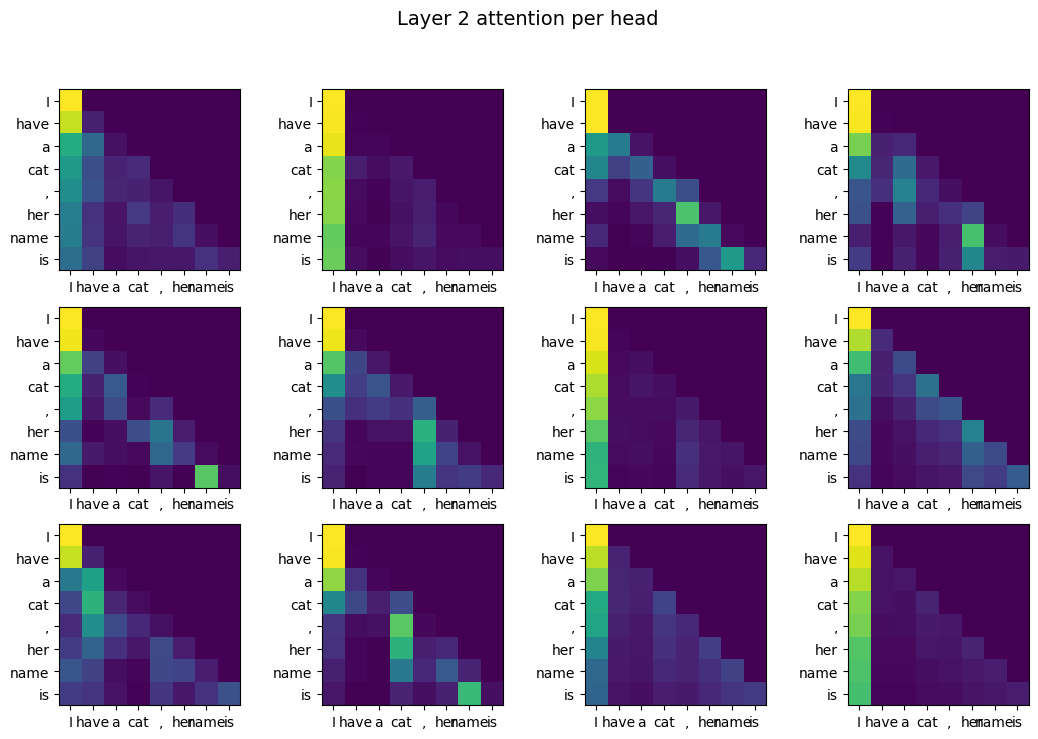

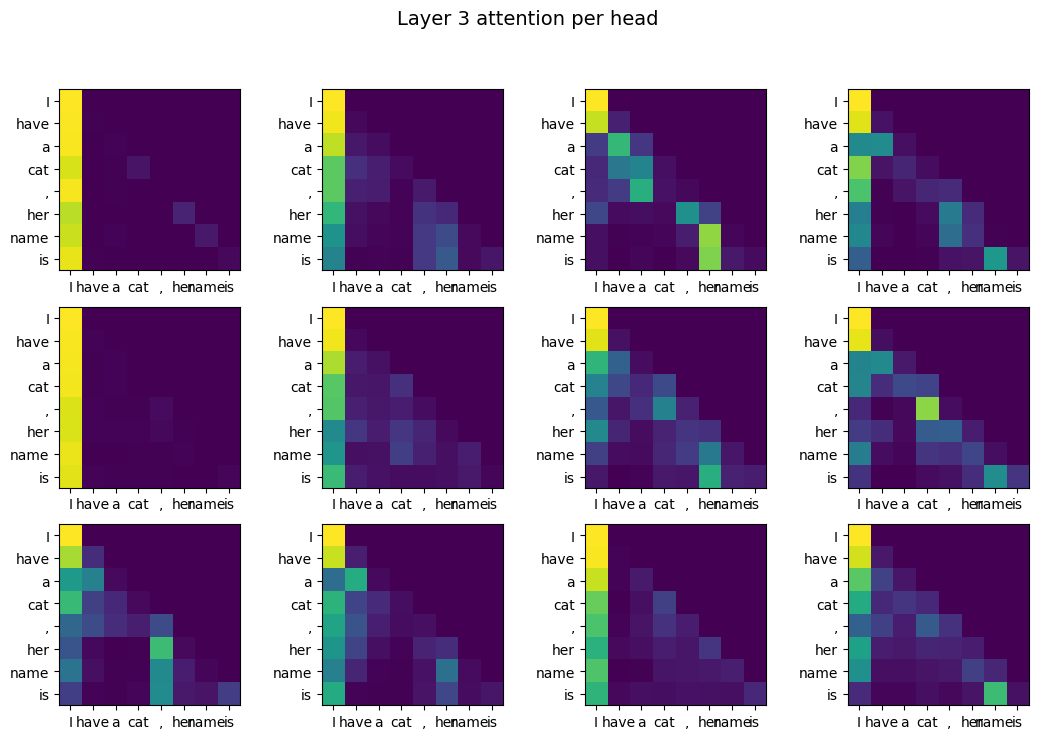

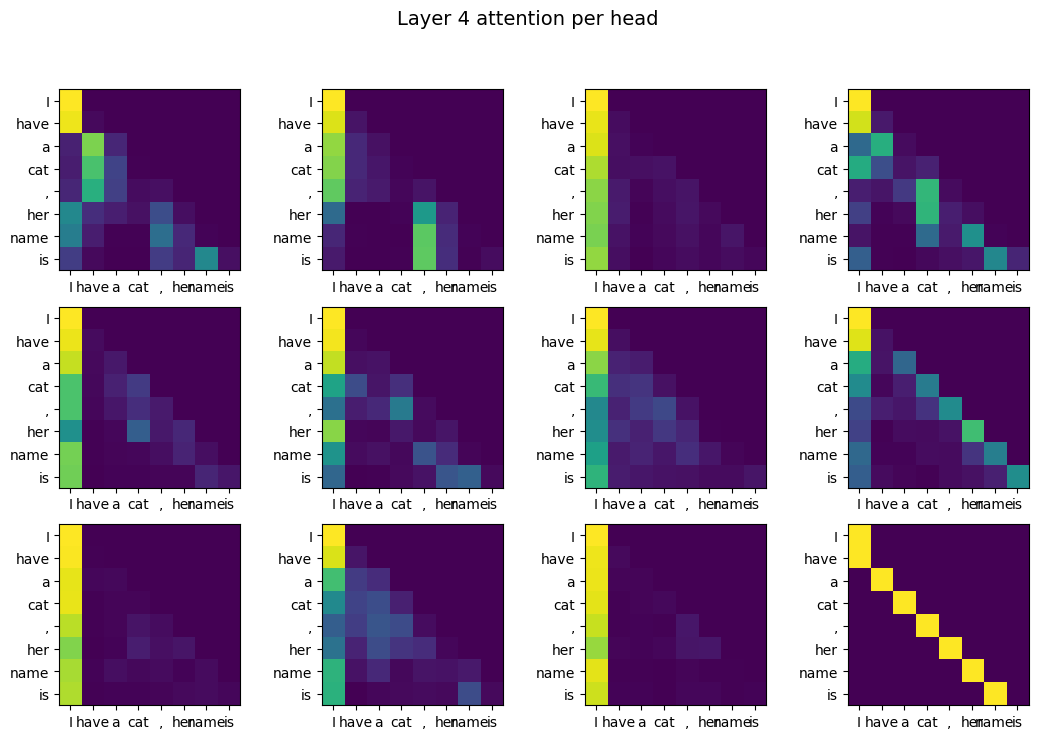

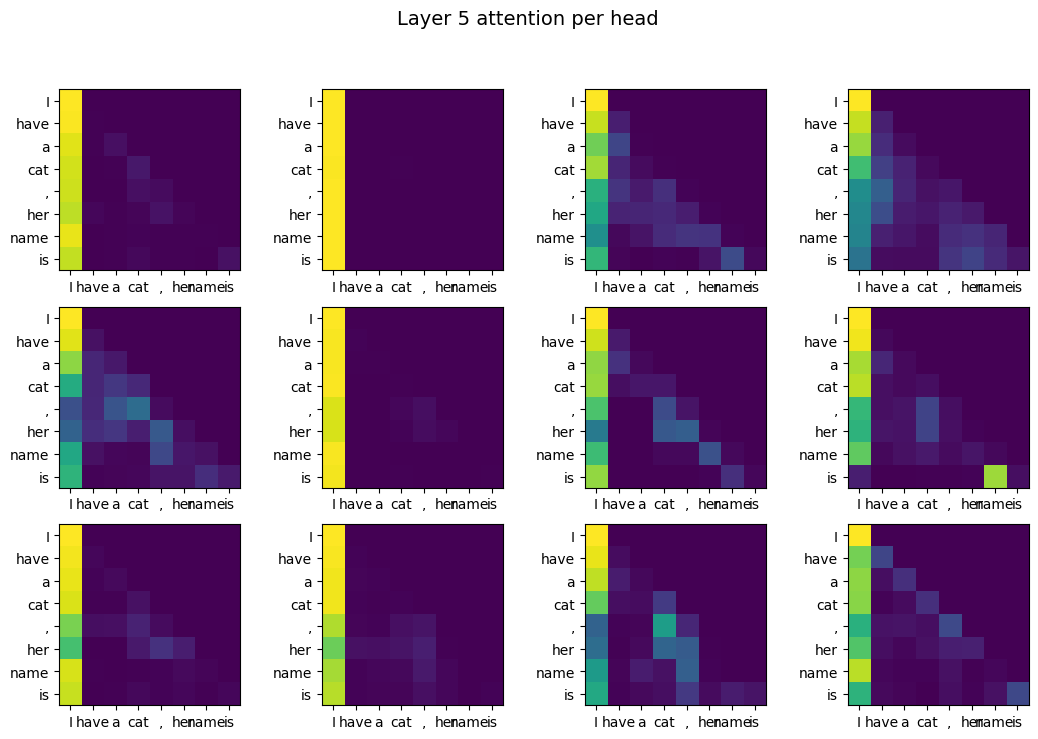

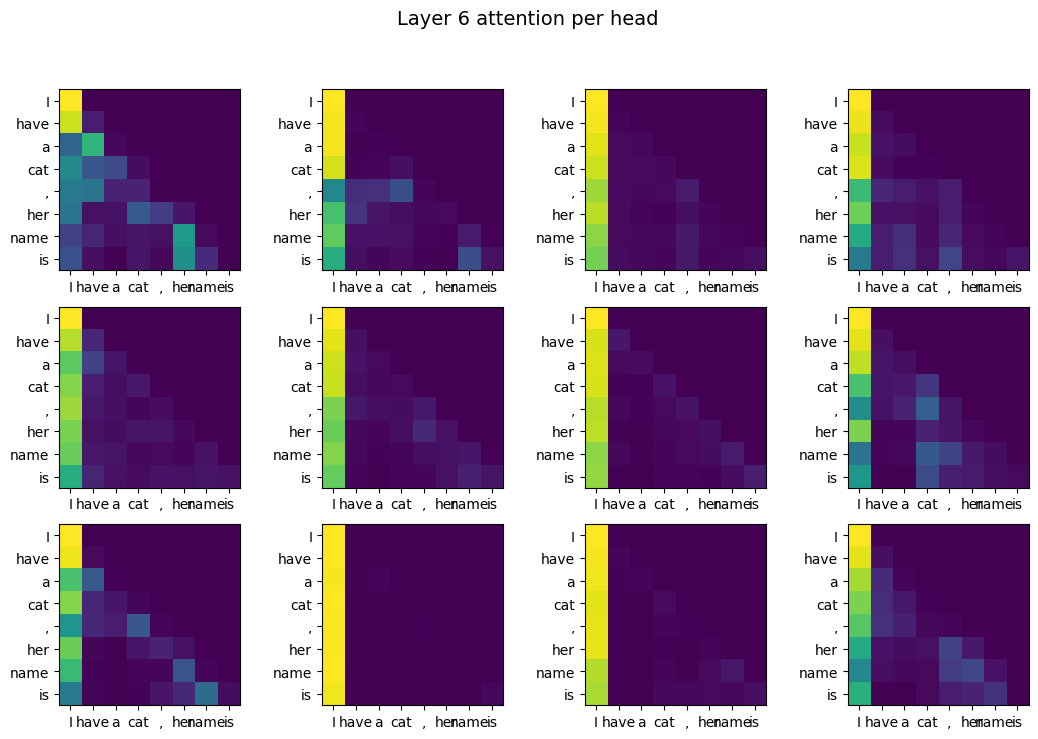

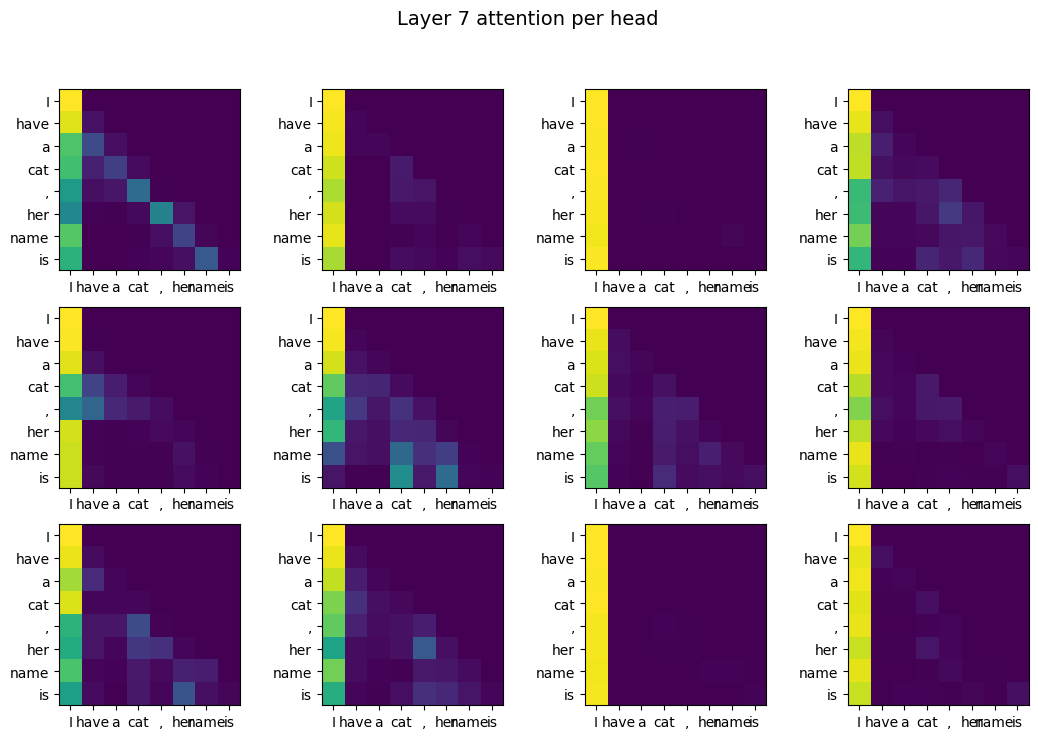

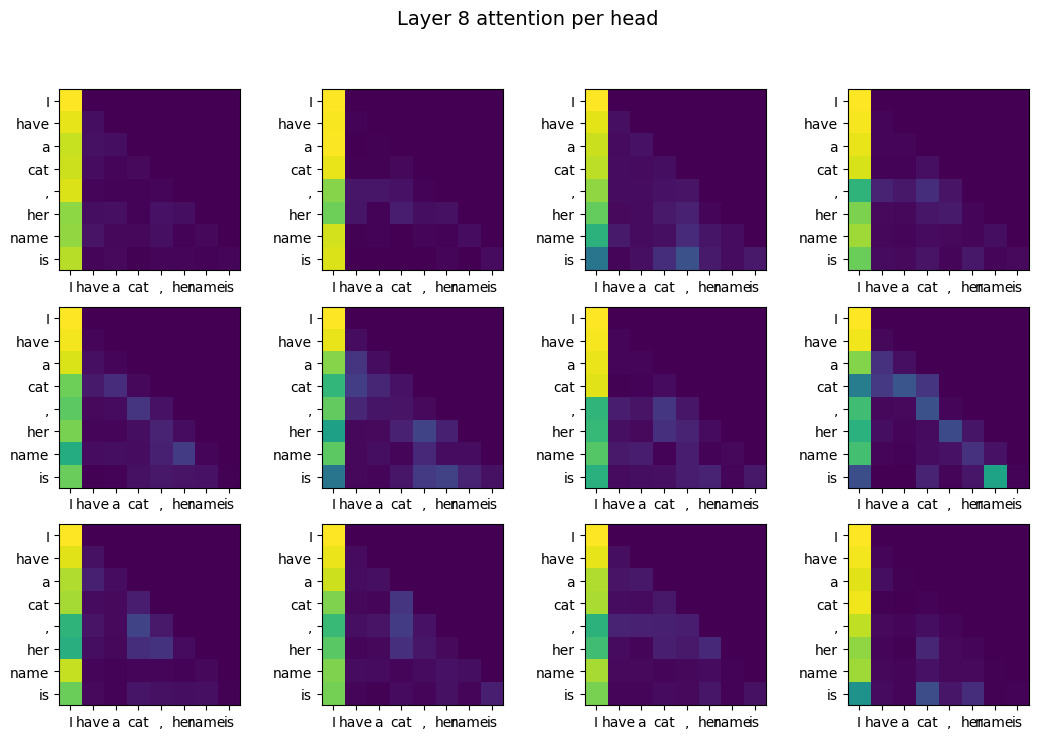

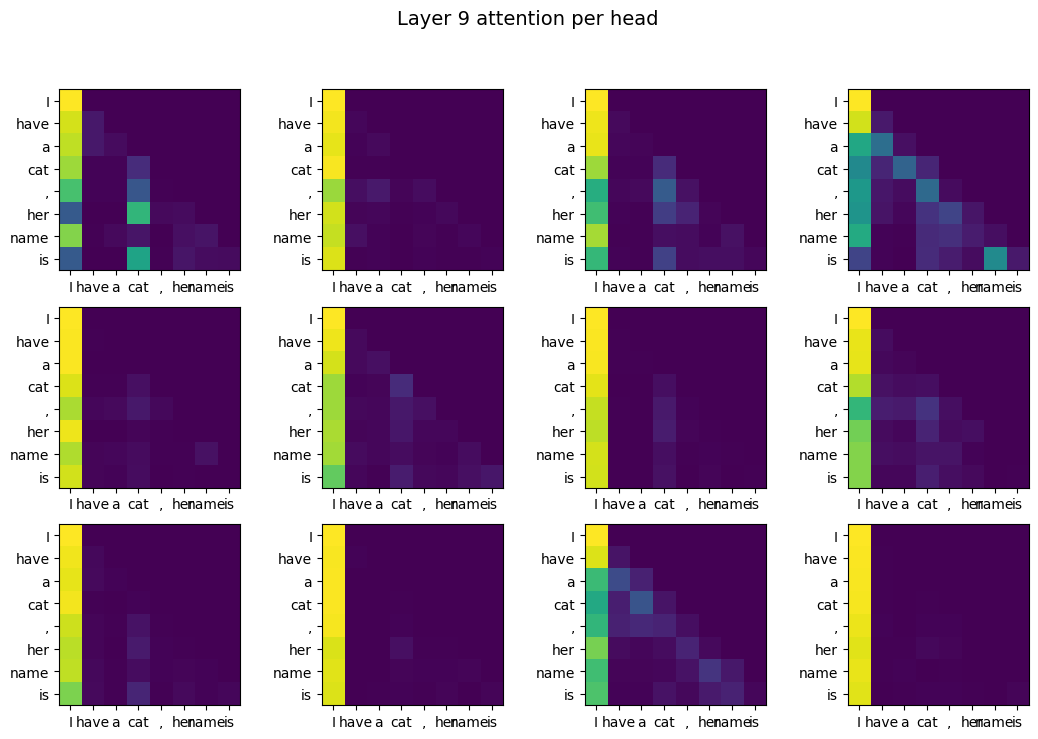

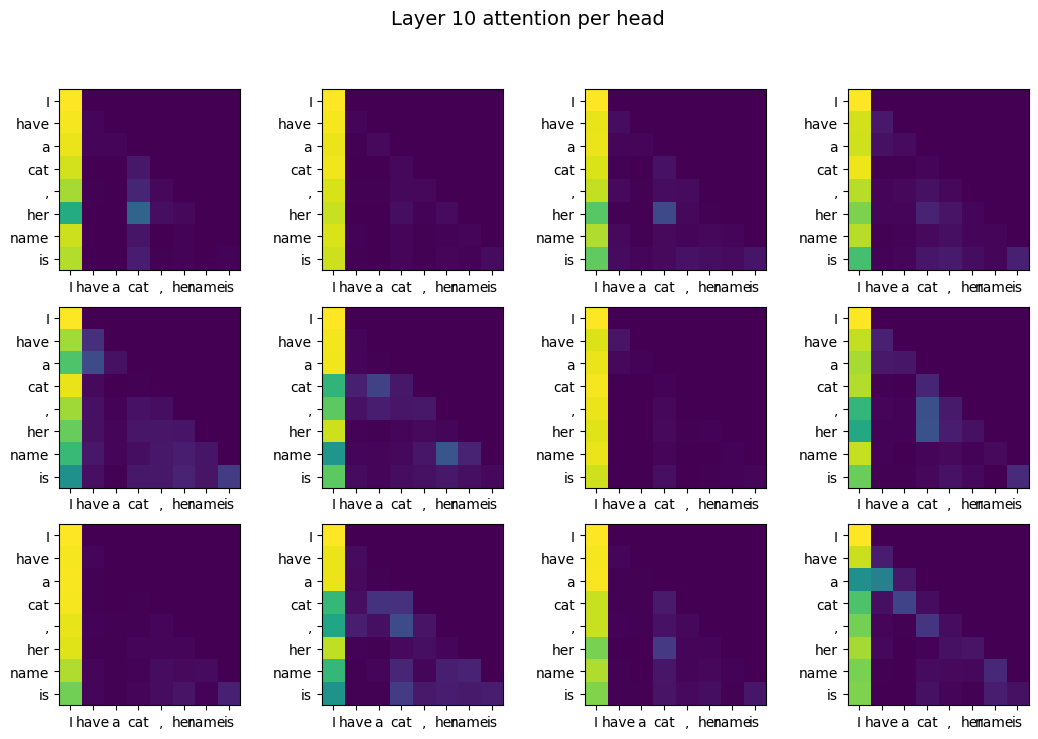

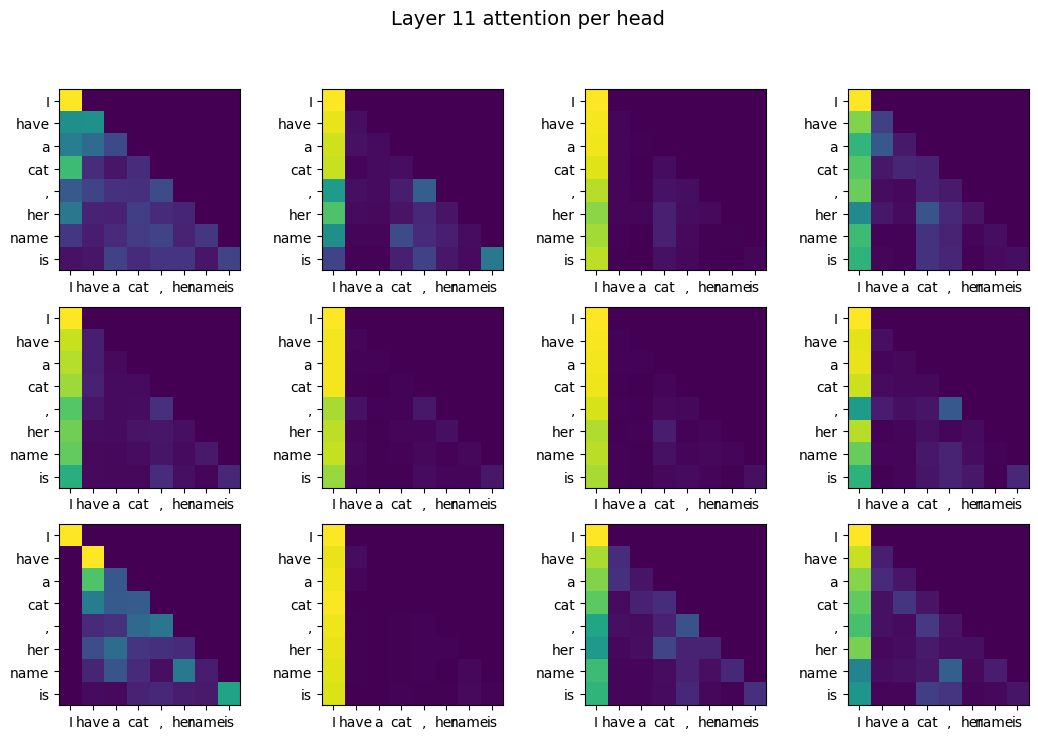

In [30]:
# @title Visualizaing attention
for layeri in range(12):
    plt.figure(figsize=(13, 8))
    for head in range(12):
        plt.subplot(3, 4, head + 1)
        plt.imshow(outputs.attentions[layeri][0, head, :, :].detach().numpy())
        plt.yticks(range(len(token_strs)), token_strs)
        plt.xticks(range(len(token_strs)), token_strs)
    plt.suptitle(f"Layer {layeri} attention per head",fontsize=14)
    plt.show()

## Extra Credit: GPT2 from scratch

If you feel ambitious, you can build a GPT2 from scratch using all the building blocks we have.

In [31]:
# @title Weight transfer utils
from transformers.activations import NewGELUActivation

def GPT2block_to_TransformerBlock_simple(tfmblock, gpt2block, ):
    """copy the weights from a GPT2 block to a TransformerBlock_simple"""
    tfmblock.ln1.weight.data = gpt2block.ln_1.weight
    tfmblock.ln1.bias.data = gpt2block.ln_1.bias
    tfmblock.ln2.weight.data = gpt2block.ln_2.weight
    tfmblock.ln2.bias.data = gpt2block.ln_2.bias
    tfmblock.attn.in_proj_weight.data = gpt2block.attn.c_attn.weight.T
    tfmblock.attn.in_proj_bias.data = gpt2block.attn.c_attn.bias
    tfmblock.attn.out_proj.weight.data = gpt2block.attn.c_proj.weight.T
    tfmblock.attn.out_proj.bias.data = gpt2block.attn.c_proj.bias
    tfmblock.ffn[0].weight.data = gpt2block.mlp.c_fc.weight.T
    tfmblock.ffn[0].bias.data = gpt2block.mlp.c_fc.bias
    tfmblock.ffn[1] = NewGELUActivation()
    # mlp in GPT2 and BERT used a new GELU activation, using nn.GeLU() will cause a small error around 1E-3
    tfmblock.ffn[2].weight.data = gpt2block.mlp.c_proj.weight.T
    tfmblock.ffn[2].bias.data = gpt2block.mlp.c_proj.bias
    return tfmblock

Let's test if our implementation of model is the same as the transformer block

In [32]:
embdim = 768
headcnt = 12
tfmblock = TransformerBlock_simple(embdim, headcnt)
GPT2block_to_TransformerBlock_simple(tfmblock, model.h[0])

tokens_embs = torch.randn(2, 5, 768)
tfmblock_out = tfmblock(tokens_embs, is_causal=True)
modelblock_out, = model.h[0](tokens_embs)
assert torch.allclose(tfmblock_out, modelblock_out, atol=1e-5, rtol=1e-5)

### Define a simple GPT2

In [33]:
class GPT2Model_simple(nn.Module):

    def __init__(self):
        super().__init__()
        self.wte = nn.Embedding(50257, 768)
        self.wpe = nn.Embedding(1024, 768)
        self.blocks = nn.ModuleList([TransformerBlock_simple(768, 12) for _ in range(12)])
        self.ln_f = nn.LayerNorm(768)

    def forward(self, input_ids, input_embeds=None, is_causal=True):
        embeds = self.wte(input_ids) if input_embeds is None else input_embeds
        embeds = embeds + self.wpe(torch.arange(embeds.shape[1], device=embeds.device))
        for block in self.blocks:
            embeds = block(embeds, is_causal=is_causal)
        return self.ln_f(embeds)


In [34]:
#@title Weight transport utils
def GPT2Model_to_GPT2Model_simple(gpt2modelsimple, gpt2model, ):
    """copy the weights from a GPT2 model to a GPT2Model_simple"""
    gpt2modelsimple.wte.weight.data = gpt2model.wte.weight
    gpt2modelsimple.wpe.weight.data = gpt2model.wpe.weight
    gpt2modelsimple.ln_f.weight.data = gpt2model.ln_f.weight
    gpt2modelsimple.ln_f.bias.data = gpt2model.ln_f.bias
    for i in range(12):
        GPT2block_to_TransformerBlock_simple(gpt2modelsimple.blocks[i], gpt2model.h[i])
    return gpt2modelsimple

In [35]:
model_ours = GPT2Model_simple()
GPT2Model_to_GPT2Model_simple(model_ours, model)

GPT2Model_simple(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock_simple(
      (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): NewGELUActivation()
        (2): Linear(in_features=3072, out_features=768, bias=True)
        (3): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [36]:
inputs = tokenizer("I have a cat, her name is", return_tensors="pt")
outputs = model(**inputs, )

In [37]:
hidden_last_ours = model_ours(inputs['input_ids'])

In [38]:
assert torch.allclose(outputs.last_hidden_state, hidden_last_ours, atol=1e-5, rtol=1e-5)

Congrats on finishing this journey of building your own GPT!

Now, let the GPU roar and train the transformer!

## What's next
**Transformer Tutorial Series**
* Fundamentals
  * [Understanding Attention & Transformer](https://colab.research.google.com/drive/1ZuhA6khlWm57WGZ8i38JH-gc5aJrvpvs?usp=sharing)
  * [Language modelling](https://colab.research.google.com/drive/1zZYzAopL__LW4glruSF9lnZYlEmSVI8j?usp=sharing)
* Beyond Language
  * [Learn to do arithmetics by sequence modelling.](https://colab.research.google.com/drive/1vO71-o-8-3IrOe44Ha0nsHmUsEGVSC37?usp=sharing)
  * [Image generation by sequence modelling.](https://colab.research.google.com/drive/1UHlEbepqdvk68cYV1fvkmWl2TBKXfm8E?usp=sharing)
  * [Audio signal classification](https://colab.research.google.com/drive/1O4XHOJyOu3_lyaPHAKJM_XTztrAb7VFP?usp=sharing) (~ 20 min)
  * [Image classification](https://colab.research.google.com/drive/1JDQQlLMGzo675AfrtkFn1kbuADtVemJz?usp=sharing) (~ 30 min)
  * [Music generation by sequence modelling.](https://colab.research.google.com/drive/14zpzLpR4UBIzEQmeaXlMv_mDFYIv3Vht?usp=sharing) (Difficult, training takes hrs)
* Using Large Language Model
  * [OpenAI API and Chat with PDF](https://colab.research.google.com/drive/19mYEyavBhOnAbEQJQuztXAxWxyYbsQzi?usp=sharing)


### See also
* Code tutorial https://nn.labml.ai/transformers/index.html



## Reference: GPT2 source code in huggingface implementation

If you are interested, we also copied the code of GPT2 within transformer library here for your review.

Implementation of a single GPT block (repetition unit of GPT)
```python
class GPT2Block(nn.Module):
    def __init__(self, config, layer_idx=None):
        super().__init__()
        hidden_size = config.hidden_size
        inner_dim = config.n_inner if config.n_inner is not None else 4 * hidden_size

        self.ln_1 = nn.LayerNorm(hidden_size, eps=config.layer_norm_epsilon)
        self.attn = GPT2Attention(config, layer_idx=layer_idx)
        self.ln_2 = nn.LayerNorm(hidden_size, eps=config.layer_norm_epsilon)

        if config.add_cross_attention:
            # attention to encoder stuff
            self.crossattention = GPT2Attention(config,
            self.ln_cross_attn = nn.LayerNorm(hidden_size, eps=config.layer_norm_epsilon)

        self.mlp = GPT2MLP(inner_dim, config)

    def forward(
        self,
        hidden_states: Optional[Tuple[torch.FloatTensor]],
        layer_past: Optional[Tuple[torch.Tensor]] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = False,
        output_attentions: Optional[bool] = False,
    ) -> Union[Tuple[torch.Tensor], Optional[Tuple[torch.Tensor, Tuple[torch.FloatTensor, ...]]]]:
        residual = hidden_states
        hidden_states = self.ln_1(hidden_states) # layernorm 1
        attn_outputs = self.attn(
            hidden_states,
            layer_past=layer_past,
            attention_mask=attention_mask,
            head_mask=head_mask,
            use_cache=use_cache,
            output_attentions=output_attentions,
        )  # attention
        attn_output = attn_outputs[0]  # output_attn: a, present, (attentions)
        outputs = attn_outputs[1:]
        # residual connection
        hidden_states = attn_output + residual

        if encoder_hidden_states is not None:
            # add one self-attention block for cross-attention
            if not hasattr(self, "crossattention"):
                raise ValueError(
                    f"If `encoder_hidden_states` are passed, {self} has to be instantiated with "
                    "cross-attention layers by setting `config.add_cross_attention=True`"
                )
            residual = hidden_states
            hidden_states = self.ln_cross_attn(hidden_states)
            cross_attn_outputs = self.crossattention(
                hidden_states,
                attention_mask=attention_mask,
                head_mask=head_mask,
                encoder_hidden_states=encoder_hidden_states,
                encoder_attention_mask=encoder_attention_mask,
                output_attentions=output_attentions,
            )
            attn_output = cross_attn_outputs[0]
            # residual connection
            hidden_states = residual + attn_output
            outputs = outputs + cross_attn_outputs[2:]  # add cross attentions if we output attention weights

        residual = hidden_states
        hidden_states = self.ln_2(hidden_states) # apply ln2 after adding attention processing.
        feed_forward_hidden_states = self.mlp(hidden_states) # mlp process the hidden state
        # residual connection
        hidden_states = residual + feed_forward_hidden_states

        if use_cache:
            outputs = (hidden_states,) + outputs
        else:
            outputs = (hidden_states,) + outputs[1:]

        return outputs  # hidden_states, present, (attentions, cross_attentions)
```

Custom designed Conv1D layer in huggingface (basically a linear layer)
```python
class Conv1D(nn.Module):
    """
    1D-convolutional layer as defined by Radford et al. for OpenAI GPT (and also used in GPT-2).
    Basically works like a linear layer but the weights are transposed.
    Args:
        nf (`int`): The number of output features.
        nx (`int`): The number of input features.
    """

    def __init__(self, nf, nx):
        super().__init__()
        self.nf = nf
        w = torch.empty(nx, nf)
        nn.init.normal_(w, std=0.02)
        self.weight = nn.Parameter(w)
        self.bias = nn.Parameter(torch.zeros(nf))

    def forward(self, x):
        size_out = x.size()[:-1] + (self.nf,)
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)
        x = x.view(size_out)
        return x
```

Attention mechanism implemented in GPT2
```python
class GPT2Attention(nn.Module):
    def __init__(self, config, is_cross_attention=False, layer_idx=None):
        super().__init__()

        max_positions = config.max_position_embeddings
        self.register_buffer(
            "bias",
            torch.tril(torch.ones((max_positions, max_positions), dtype=torch.uint8)).view(
                1, 1, max_positions, max_positions
            ),
        )
        self.register_buffer("masked_bias", torch.tensor(-1e4))

        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.embed_dim // self.num_heads
        self.split_size = self.embed_dim
        if self.head_dim * self.num_heads != self.embed_dim:
            raise ValueError(
                f"`embed_dim` must be divisible by num_heads (got `embed_dim`: {self.embed_dim} and `num_heads`:"
                f" {self.num_heads})."
            )

        self.scale_attn_weights = config.scale_attn_weights
        self.is_cross_attention = is_cross_attention

        # Layer-wise attention scaling, reordering, and upcasting
        self.scale_attn_by_inverse_layer_idx = config.scale_attn_by_inverse_layer_idx
        self.layer_idx = layer_idx
        self.reorder_and_upcast_attn = config.reorder_and_upcast_attn

        if self.is_cross_attention:
            self.c_attn = Conv1D(2 * self.embed_dim, self.embed_dim)
            self.q_attn = Conv1D(self.embed_dim, self.embed_dim)
        else:
            self.c_attn = Conv1D(3 * self.embed_dim, self.embed_dim)
        self.c_proj = Conv1D(self.embed_dim, self.embed_dim)

        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)

        self.pruned_heads = set()

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(heads, self.num_heads, self.head_dim, self.pruned_heads)
        index_attn = torch.cat([index, index + self.split_size, index + (2 * self.split_size)])

        # Prune conv1d layers
        self.c_attn = prune_conv1d_layer(self.c_attn, index_attn, dim=1)
        self.c_proj = prune_conv1d_layer(self.c_proj, index, dim=0)

        # Update hyper params
        self.split_size = (self.split_size // self.num_heads) * (self.num_heads - len(heads))
        self.num_heads = self.num_heads - len(heads)
        self.pruned_heads = self.pruned_heads.union(heads)

    def _attn(self, query, key, value, attention_mask=None, head_mask=None):
        attn_weights = torch.matmul(query, key.transpose(-1, -2))

        if self.scale_attn_weights:
            attn_weights = attn_weights / torch.tensor(
                value.size(-1) ** 0.5, dtype=attn_weights.dtype, device=attn_weights.device
            )

        # Layer-wise attention scaling
        if self.scale_attn_by_inverse_layer_idx:
            attn_weights = attn_weights / float(self.layer_idx + 1)

        if not self.is_cross_attention:
            # if only "normal" attention layer implements causal mask
            query_length, key_length = query.size(-2), key.size(-2)
            causal_mask = self.bias[:, :, key_length - query_length : key_length, :key_length].to(torch.bool)
            mask_value = torch.finfo(attn_weights.dtype).min
            # Need to be a tensor, otherwise we get error: `RuntimeError: expected scalar type float but found double`.
            # Need to be on the same device, otherwise `RuntimeError: ..., x and y to be on the same device`
            mask_value = torch.tensor(mask_value, dtype=attn_weights.dtype).to(attn_weights.device)
            attn_weights = torch.where(causal_mask, attn_weights, mask_value)

        if attention_mask is not None:
            # Apply the attention mask
            attn_weights = attn_weights + attention_mask

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)

        # Downcast (if necessary) back to V's dtype (if in mixed-precision) -- No-Op otherwise
        attn_weights = attn_weights.type(value.dtype)
        attn_weights = self.attn_dropout(attn_weights)

        # Mask heads if we want to
        if head_mask is not None:
            attn_weights = attn_weights * head_mask

        attn_output = torch.matmul(attn_weights, value)

        return attn_output, attn_weights

    def _upcast_and_reordered_attn(self, query, key, value, attention_mask=None, head_mask=None):
        # Use `torch.baddbmm` (a bit more efficient w/ alpha param for scaling -- from Megatron-LM)
        bsz, num_heads, q_seq_len, dk = query.size()
        _, _, k_seq_len, _ = key.size()

        # Preallocate attn_weights for `baddbmm`
        attn_weights = torch.empty(bsz * num_heads, q_seq_len, k_seq_len, dtype=torch.float32, device=query.device)

        # Compute Scale Factor
        scale_factor = 1.0
        if self.scale_attn_weights:
            scale_factor /= float(value.size(-1)) ** 0.5

        if self.scale_attn_by_inverse_layer_idx:
            scale_factor /= float(self.layer_idx + 1)

        # Upcast (turn off autocast) and reorder (Scale K by 1 / root(dk))
        with autocast(enabled=False):
            q, k = query.reshape(-1, q_seq_len, dk), key.transpose(-1, -2).reshape(-1, dk, k_seq_len)
            attn_weights = torch.baddbmm(attn_weights, q.float(), k.float(), beta=0, alpha=scale_factor)
            attn_weights = attn_weights.reshape(bsz, num_heads, q_seq_len, k_seq_len)

        if not self.is_cross_attention:
            # if only "normal" attention layer implements causal mask
            query_length, key_length = query.size(-2), key.size(-2)
            causal_mask = self.bias[:, :, key_length - query_length : key_length, :key_length].bool()
            mask_value = torch.finfo(attn_weights.dtype).min
            # Need to be a tensor, otherwise we get error: `RuntimeError: expected scalar type float but found double`.
            # Need to be on the same device, otherwise `RuntimeError: ..., x and y to be on the same device`
            mask_value = torch.tensor(mask_value, dtype=attn_weights.dtype).to(attn_weights.device)
            attn_weights = torch.where(causal_mask, attn_weights, mask_value)

        if attention_mask is not None:
            # Apply the attention mask
            attn_weights = attn_weights + attention_mask

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)

        # Downcast (if necessary) back to V's dtype (if in mixed-precision) -- No-Op if otherwise
        if attn_weights.dtype != torch.float32:
            raise RuntimeError("Error with upcasting, attn_weights does not have dtype torch.float32")
        attn_weights = attn_weights.type(value.dtype)
        attn_weights = self.attn_dropout(attn_weights)

        # Mask heads if we want to
        if head_mask is not None:
            attn_weights = attn_weights * head_mask

        attn_output = torch.matmul(attn_weights, value)

        return attn_output, attn_weights

    def _split_heads(self, tensor, num_heads, attn_head_size):
        """
        Splits hidden_size dim into attn_head_size and num_heads
        """
        new_shape = tensor.size()[:-1] + (num_heads, attn_head_size)
        tensor = tensor.view(new_shape) # (batch, seq_len, headnum, head_features)
        return tensor.permute(0, 2, 1, 3)  # (batch, head, seq_length, head_features)

    def _merge_heads(self, tensor, num_heads, attn_head_size):
        """
        Merges attn_head_size dim and num_attn_heads dim into hidden_size
        """
        tensor = tensor.permute(0, 2, 1, 3).contiguous()
        new_shape = tensor.size()[:-2] + (num_heads * attn_head_size,)
        return tensor.view(new_shape)

    def forward(
        self,
        hidden_states: Optional[Tuple[torch.FloatTensor]],
        layer_past: Optional[Tuple[torch.Tensor]] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = False,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[Union[torch.Tensor, Tuple[torch.Tensor]], ...]:
        if encoder_hidden_states is not None:
            if not hasattr(self, "q_attn"):
                raise ValueError(
                    "If class is used as cross attention, the weights `q_attn` have to be defined. "
                    "Please make sure to instantiate class with `GPT2Attention(..., is_cross_attention=True)`."
                )

            query = self.q_attn(hidden_states)
            key, value = self.c_attn(encoder_hidden_states).split(self.split_size, dim=2)
            attention_mask = encoder_attention_mask
        else:
            query, key, value = self.c_attn(hidden_states).split(self.split_size, dim=2)

        query = self._split_heads(query, self.num_heads, self.head_dim)
        key = self._split_heads(key, self.num_heads, self.head_dim)
        value = self._split_heads(value, self.num_heads, self.head_dim)

        if layer_past is not None:
            past_key, past_value = layer_past
            key = torch.cat((past_key, key), dim=-2)
            value = torch.cat((past_value, value), dim=-2)

        if use_cache is True:
            present = (key, value)
        else:
            present = None

        if self.reorder_and_upcast_attn:
            attn_output, attn_weights = self._upcast_and_reordered_attn(query, key, value, attention_mask, head_mask)
        else:
            attn_output, attn_weights = self._attn(query, key, value, attention_mask, head_mask)

        attn_output = self._merge_heads(attn_output, self.num_heads, self.head_dim)
        attn_output = self.c_proj(attn_output)
        attn_output = self.resid_dropout(attn_output)

        outputs = (attn_output, present)
        if output_attentions:
            outputs += (attn_weights,)

        return outputs  # a, present, (attentions)
```

MLP in GPT2.
```python
class GPT2MLP(nn.Module):
    def __init__(self, intermediate_size, config):
        super().__init__()
        embed_dim = config.hidden_size
        self.c_fc = Conv1D(intermediate_size, embed_dim)
        self.c_proj = Conv1D(embed_dim, intermediate_size)
        self.act = ACT2FN[config.activation_function]
        self.dropout = nn.Dropout(config.resid_pdrop)

    def forward(self, hidden_states: Optional[Tuple[torch.FloatTensor]]) -> torch.FloatTensor:
        hidden_states = self.c_fc(hidden_states)
        hidden_states = self.act(hidden_states)
        hidden_states = self.c_proj(hidden_states)
        hidden_states = self.dropout(hidden_states)
        return hidden_states
```